# CNN for post-processing
The idea is to create a stack of neural networks. Where the second one takes the predictions from the first one as inputs. This second CNN should clean up the prediction e.g. remove noise and close roads. This is possible with a CNN because of the relation between adjecent labels

In [1]:
from helpers.dataset_preprocessing import create_dataset, extract_patches, compute_input_features, compute_output_features,load_image,img_crop_translate
from helpers.dataset_postprocessing import unpatch
from helpers.feature_extractors import extract_features, extract_features_2d, value_to_class, value_to_2d_class, img_to_label
from helpers.visualization_helpers import *
from helpers.CNN_helpers import *
from skimage import img_as_float, img_as_uint


import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as n

%matplotlib inline

Using TensorFlow backend.


In [2]:
# GLOBAL VARIABLES
ROOT_DIR = "post2/"
TOTAL_IMAGES = 100 # Number of images to load
TRAIN_FRACTION = 1 # Percentage of images used for training
PATCH_SIZE = 8
PATCH_TRANSLATION = 0
FOREGROUND_THRESHOLD = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
ORIGINAL_IMAGE_WIDTH = 400
ORIGINAL_IMAGE_HEIGHT = 400
NUM_CHANNELS = 3
THEANO = False

In [13]:
def dont_extract(input):
    return input

In [14]:
dataset = create_dataset(ROOT_DIR, TOTAL_IMAGES, TRAIN_FRACTION)
patches = extract_patches(dataset, PATCH_SIZE, PATCH_TRANSLATION)

input_features = compute_input_features(patches[0:2], dont_extract) # train_img_patches and test_img_patches
output_features = compute_output_features(patches[2:4], value_to_2d_class, FOREGROUND_THRESHOLD) # train_gt_img_patches and test_gt_img_patches

from skimage import img_as_float
    
X_train = img_as_float(input_features[0])
Y_train = output_features[0].astype(np.float32)
X_test = img_as_float(input_features[1])
Y_test = output_features[1].astype(np.float32)

Original loaded dataset size: 100
Creating train dataset...
Creating test dataset...
Created train dataset size: 100
Created test dataset size: 0
Train patches: 250000
Test patches: 0
Train GT patches: 250000
Test GT patches: 0
Train features: 250000
Test features: 0
Train GT features: 250000
Test GT features: 0


In [ ]:
aa= dataset[1]

imga = Image.fromarray(aa[0])
# imga.show()

In [ ]:
bb = dataset[2]

imgb = Image.fromarray(bb[0])
# imgb.show()

In [17]:
from __future__ import print_function
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.optimizers import SGD
from keras import backend as K

batch_size = 128
nb_classes = 2


# ********** Tuning parameters: (See Network architecture as well)

# Epochs to be trained
nb_epoch = 4
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 3)

"""
if "image_dim_ordering": is "th" and "backend": "theano", your input_shape must be (channels, height, width)
if "image_dim_ordering": is "tf" and "backend": "tensorflow", your input_shape must be (height, width, channels)
"""
if THEANO:
    input_shape = (NUM_CHANNELS, PATCH_SIZE, PATCH_SIZE)
else:
    input_shape = (PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS)

def train_cnn(model_name='post_CNN.h5'):


    # **************** DEFINE THE MODEL ARCHITECTURE *******************

    model = Sequential()

    # Convolution layer with rectified linear activation
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],border_mode='same',input_shape=input_shape))
    model.add(Activation('relu'))

    # Second convolution
    model.add(Convolution2D(nb_filters, kernel_size[1], kernel_size[0]))
    model.add(Activation('relu'))

    model.add(Dropout(0.25))

    # Third convolution
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[0]))
    model.add(Activation('relu'))

    # Pooling and dropout
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    # Full-connected layer
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))

    model.add(Dense(1024))
    model.add(Activation('relu'))

    # Dropout to avoid overfitting
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(Activation('relu'))

    # Dropout to avoid overfitting
    model.add(Dropout(0.5))

    #Fully-connected layer to ouptut the resulting class
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['fmeasure'])

    print(X_train.shape)
    #class_weight = auto??
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, class_weight='auto', verbose=1)#, validation_data=(X_test, Y_test))


#     score = model.evaluate(X_test, Y_test, verbose=0)
#     print('Test score:', score[0])
#     print('Test accuracy:', score[1])

    model.save('models/' + model_name)
    
    data_dir = 'post2/images/'
    pred_dir = 'post2/prediction/'
    for i in range(80, 101):
        num = str(i).zfill(3)
        imageid = "prediction_" + num
        image_filename = data_dir + imageid + ".png"
        if os.path.isfile(image_filename):
            print ('Predicting ' + image_filename)
            
            # If using img_crop_translate:
            #img = mpimg.imread(image_filename)
            #data = np.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))


            # If using img_crop_translate:
            pil_img = Image.open(image_filename)
            pil_img = pil_img.convert('RGB')
            img = np.array(pil_img)
            data = np.asarray(img_as_float(img_crop_translate(img, PATCH_SIZE, PATCH_SIZE, 0, 0)), dtype='float32')
            

            predictions_patch = model.predict_classes(data, verbose=1)

            img_prediction = label_to_img(img.shape[0], img.shape[1], 
                                          PATCH_SIZE, PATCH_SIZE, 
                                          predictions_patch)

            pimg = Image.fromarray((img_prediction*255.0).astype(np.uint8))
            pimg = ImageOps.invert(pimg)
            pimg = pimg.rotate(90)
            pimg = ImageOps.flip(pimg)
            pimg.save(pred_dir + "prediction_" + num + ".png")

        else:
            print ('File ' + image_filename + ' does not exist')

In [18]:
train_cnn()

(250000, 8, 8, 3)
Epoch 1/4
250000/250000 [==============================] - 227s - loss: 0.4732 - fmeasure: 0.8165   
Epoch 2/4
250000/250000 [==============================] - 231s - loss: 0.4705 - fmeasure: 0.8178   
Epoch 3/4
250000/250000 [==============================] - 235s - loss: 0.4697 - fmeasure: 0.8178   
Epoch 4/4
250000/250000 [==============================] - 233s - loss: 0.4696 - fmeasure: 0.8178   
Predicting post2/images/prediction_080.png
2500/2500 [==============================] - 0s     
Predicting post2/images/prediction_088.png
2500/2500 [==============================] - 0s     
Predicting post2/images/prediction_089.png
2500/2500 [==============================] - 0s     
Predicting post2/images/prediction_092.png
2500/2500 [==============================] - 0s     
Predicting post2/images/prediction_094.png
2500/2500 [==============================] - 0s     
Predicting post2/images/prediction_097.png
2500/2500 [==============================] - 0s     
Pr

### Optional: load post procesing CNN straight from file

In [ ]:
from keras.models import load_model
model = load_model('models/post_CNN.h5')

predict_imgs(model=model, data_dir='post2/images/', prediction_root_dir='post2/prediction/', no_of_imgs=100, img_name='prediction')

### More post processing with morphological filters

In [4]:
from skimage.util import img_as_ubyte
from skimage import io
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk, square

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

road = img_as_ubyte(io.imread('post2/prediction/prediction_093.png', as_grey=True))
gt = img_as_ubyte(io.imread('post2/groundtruth/satImage_093.png', as_grey=True))

In [5]:
gt_labels = img_to_label(gt, PATCH_SIZE, PATCH_SIZE, value_to_class, FOREGROUND_THRESHOLD)

In [6]:
road_labels = img_to_label(road, PATCH_SIZE, PATCH_SIZE, value_to_class, FOREGROUND_THRESHOLD)

#### Baseline right after post processing CNN

In [7]:
confusion_matrix(gt_labels, road_labels)

array([[1631,   84],
       [ 230,  555]])

In [8]:
f1_score(gt_labels, road_labels) 

0.77949438202247179

In [9]:
def plot_comparison(gt, original, filtered, filter_name):

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(gt, cmap=plt.cm.gray)
    ax1.set_title('Groundtruth')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(original, cmap=plt.cm.gray)
    ax2.set_title('original')
    ax2.axis('off')
    ax2.set_adjustable('box-forced')
    ax3.imshow(filtered, cmap=plt.cm.gray)
    ax3.set_title(filter_name)
    ax3.axis('off')
    ax3.set_adjustable('box-forced')

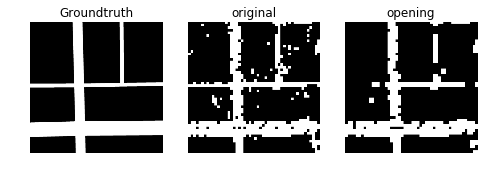

In [10]:
selem = square(9) # segmentation element
opened = opening(road, selem)
plot_comparison(gt, road, opened, 'opening')

In [11]:
opened_labels = img_to_label(opened, PATCH_SIZE, PATCH_SIZE, value_to_class, FOREGROUND_THRESHOLD)
f1_score(gt_labels, opened_labels)

0.764484574868322

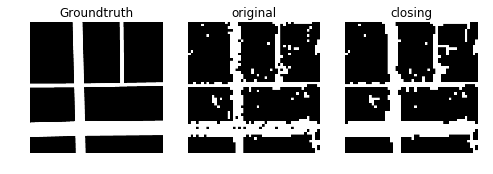

In [12]:
selem = square(9)
closed = closing(road, selem)
plot_comparison(gt, road, closed, 'closing')

In [13]:
closed_labels = img_to_label(closed, PATCH_SIZE, PATCH_SIZE, value_to_class, FOREGROUND_THRESHOLD)
f1_score(gt_labels, closed_labels)

0.8124156545209178

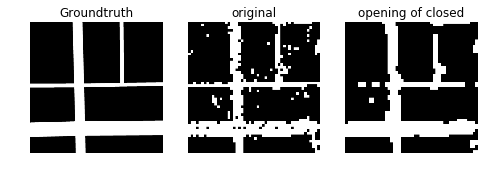

In [14]:
selem = square(9)
open_closed = opening(closed, selem)
plot_comparison(gt, road, open_closed, 'opening of closed')

In [15]:
open_closed_labels = img_to_label(open_closed, PATCH_SIZE, PATCH_SIZE, value_to_class, FOREGROUND_THRESHOLD)
f1_score(gt_labels, open_closed_labels)

0.81985815602836876

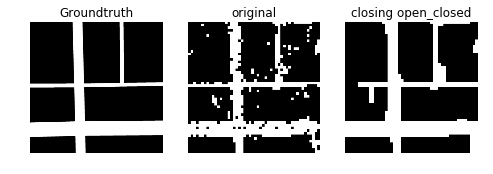

In [16]:
selem = square(35)
closed_open_closed = closing(open_closed, selem)
plot_comparison(gt, road, closed_open_closed, 'closing open_closed')

In [17]:
closed_open_closed_labels = img_to_label(closed_open_closed, PATCH_SIZE, PATCH_SIZE, value_to_class, FOREGROUND_THRESHOLD)
f1_score(gt_labels, closed_open_closed_labels)

0.85097774780849633